In [2]:
import pyspark
from pyspark import SparkContext as sc
from pyspark import SparkConf
import numpy as np
from pyspark.sql import types as T, SparkSession
# from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import matplotlib as mpl
conf=SparkConf().setAppName("DBSCAN").setMaster("local[*]")
sc=sc.getOrCreate(conf)

In [3]:
def parseVector(line):
    return np.array([float(x) for x in line.split()])

def nearest_neighbour(iterator):
    point_list = data_total.value
    for p in iterator:
        neighbour = []
        for i in range(len(point_list)):
            dis = np.sum((p[1] - point_list[i][1]) ** 2)
            if dis < (min_dis ** 2):
                neighbour.append(point_list[i][0])

        yield list((p[0], (neighbour, len(neighbour) - 1)))

def f(iterator):
    yield len(list(iterator))


def give_id(index, iterator):
    global sums
    if index == 0:
        s = 0
    else:
        s = sums[index-1]
    for pair in iterator:
        s += 1
        yield s, pair

In [4]:
def load_point(path):
    points = sc.textFile(path).map(lambda x: x.strip().split()[:]).map(lambda x: tuple([float(i) for i in x]))
    return points.collect()

def plain_picture(fileName, ax):
    # draw original plot
    X = np.array(load_point(fileName))
#     labels_true = np.array(load_label(fileName))
    
    ax[0].plot(X[:, 0], X[:, 1], 'o', markerfacecolor=[0, 0, 0, 1],
                 markeredgecolor='k', markersize=3, scalex=1, scaley=1)
    ax[0].set_title('plot of '+fileName[8:-4])
    return X

def processed_picture(X, ax, N, labelList,fileName):
    N += 1

    # define the colormap
    cmap = plt.cm.jet
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
    bounds = np.linspace(0,N,N+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
#     fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(6,6))
    scat = ax[1].scatter([i[0] for i in X],[i[1] for i in X],c=labelList,s=None,cmap=cmap,norm=norm)
    cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
    cb.set_label('Custom cbar')
    ax[1].set_title('DBSCAN Result of '+fileName[8:-4])
    plt.show()

In [5]:
import time

naive_dbscan run time on spiral.txt: 2.370408058166504


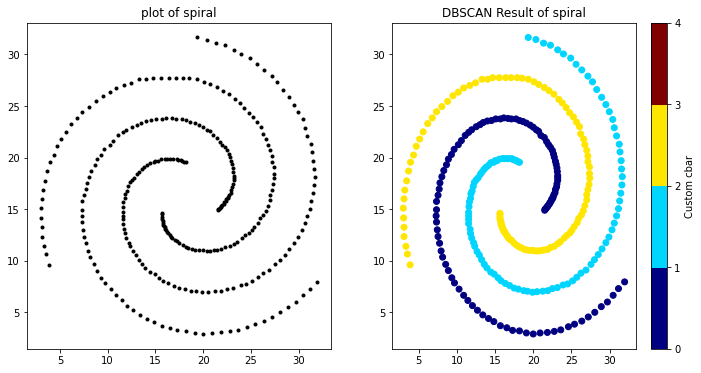

In [5]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
fileName = 'dataset/spiral.txt'
X = plain_picture(fileName,ax)

start_time = time.time()

lines = sc.textFile(fileName, 5)
min_dis = 3.6
min_point = 2

data = lines.map(parseVector).cache()  # data is an RDD of arrays

sums = data.mapPartitions(f).collect()

for i in range(1, len(sums)):
    sums[i] += sums[i - 1]

# print(sums)

# allocate id
data_id = data.mapPartitionsWithIndex(give_id)

data_broad = data_id.collect()
data_total = sc.broadcast(data_broad)

# data = sc.parallelize(data_id, 4).cache()

data_length = data_id.count()

# reduce O(n) to O(n/p)
neighbourhood = data_id.mapPartitions(nearest_neighbour).cache()
# print(neighbourhood.collect())

data_calculate = neighbourhood.collect()
# print(data_calculate)

label_data = {}

# running in driver, not parallel
# initialize as {id : id}
for i in range(len(data_calculate)):
    label_data[data_calculate[i][0]] = data_calculate[i][0]

# print(label_data)

# put the first core point's id as the cluster_label
for i in range(len(data_calculate)):
    if data_calculate[i][1][1] >= min_point:
        cluster_label = label_data[data_calculate[i][0]]
        for idj in data_calculate[i][1][0]:
            label_data[idj] = cluster_label

# print(label_data)

label_set = []
clusters = -1
labelList = []
for i in range(1,len(label_data)+1):
    if label_data[i] not in label_set:
        label_set.append(label_data[i])
        clusters+=1
    labelList.append(clusters)
    
end_time = time.time()
print('naive_dbscan run time on spiral.txt:', end_time - start_time)

processed_picture(X,ax,len(label_set),labelList,fileName)

naive_dbscan run time on flame.txt: 0.7402684688568115


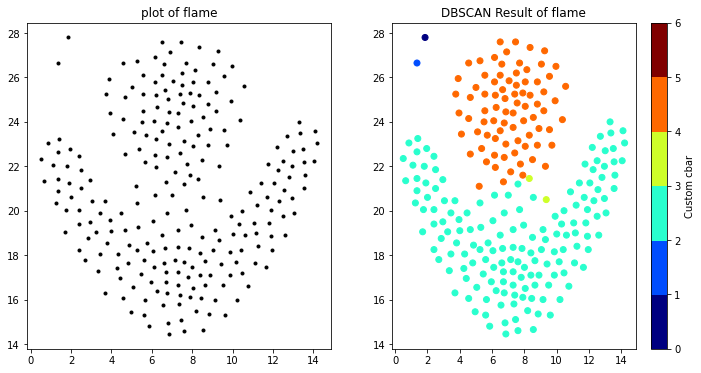

In [17]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
fileName = 'dataset/flame.txt'
X = plain_picture(fileName,ax)

start_time = time.time()

lines = sc.textFile(fileName, 5)
min_dis = 1.35
min_point = 5

data = lines.map(parseVector).cache()  # data is an RDD of arrays

sums = data.mapPartitions(f).collect()

for i in range(1, len(sums)):
    sums[i] += sums[i - 1]

# print(sums)

# allocate id
data_id = data.mapPartitionsWithIndex(give_id)

data_broad = data_id.collect()
data_total = sc.broadcast(data_broad)

# data = sc.parallelize(data_id, 4).cache()

data_length = data_id.count()

# reduce O(n) to O(n/p)
neighbourhood = data_id.mapPartitions(nearest_neighbour).cache()
# print(neighbourhood.collect())

data_calculate = neighbourhood.collect()
# print(data_calculate)

label_data = {}

# running in driver, not parallel
# initialize as {id : id}
for i in range(len(data_calculate)):
    label_data[data_calculate[i][0]] = data_calculate[i][0]

# print(label_data)

# put the first core point's id as the cluster_label
for i in range(len(data_calculate)):
    if data_calculate[i][1][1] >= min_point:
        cluster_label = label_data[data_calculate[i][0]]
        for idj in data_calculate[i][1][0]:
            label_data[idj] = cluster_label

# print(label_data)

label_set = []
clusters = -1
labelList = []
for i in range(1,len(label_data)+1):
    if label_data[i] not in label_set:
        label_set.append(label_data[i])
        clusters+=1
    labelList.append(clusters)
    
end_time = time.time()
print('naive_dbscan run time on flame.txt:', end_time - start_time)

processed_picture(X,ax,len(label_set),labelList,fileName)

naive_dbscan run time on R15.txt: 1.928926944732666


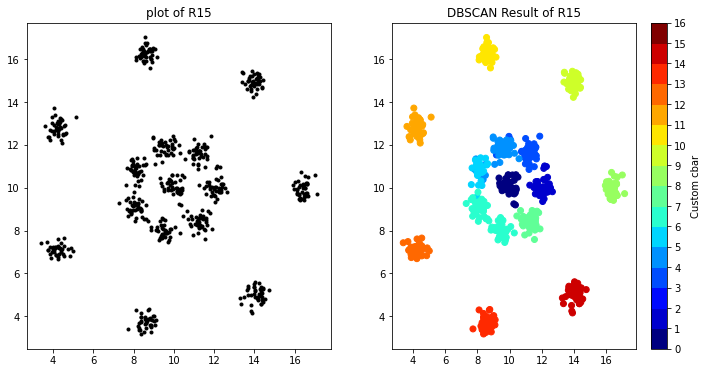

In [18]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
fileName = 'dataset/R15.txt'
X = plain_picture(fileName,ax)

start_time = time.time()

lines = sc.textFile(fileName, 5)
min_dis = 1.1
min_point = 5

data = lines.map(parseVector).cache()  # data is an RDD of arrays

sums = data.mapPartitions(f).collect()

for i in range(1, len(sums)):
    sums[i] += sums[i - 1]

# print(sums)

# allocate id
data_id = data.mapPartitionsWithIndex(give_id)

data_broad = data_id.collect()
data_total = sc.broadcast(data_broad)

# data = sc.parallelize(data_id, 4).cache()

data_length = data_id.count()

# reduce O(n) to O(n/p)
neighbourhood = data_id.mapPartitions(nearest_neighbour).cache()
# print(neighbourhood.collect())

data_calculate = neighbourhood.collect()
# print(data_calculate)

label_data = {}

# running in driver, not parallel
# initialize as {id : id}
for i in range(len(data_calculate)):
    label_data[data_calculate[i][0]] = data_calculate[i][0]

# print(label_data)

# put the first core point's id as the cluster_label
for i in range(len(data_calculate)):
    if data_calculate[i][1][1] >= min_point:
        cluster_label = label_data[data_calculate[i][0]]
        for idj in data_calculate[i][1][0]:
            label_data[idj] = cluster_label

# print(label_data)

label_set = []
clusters = -1
labelList = []
for i in range(1,len(label_data)+1):
    if label_data[i] not in label_set:
        label_set.append(label_data[i])
        clusters+=1
    labelList.append(clusters)
    
end_time = time.time()
print('naive_dbscan run time on R15.txt:', end_time - start_time)

processed_picture(X,ax,len(label_set),labelList,fileName)

naive_dbscan run time on D31.txt: 41.42207622528076


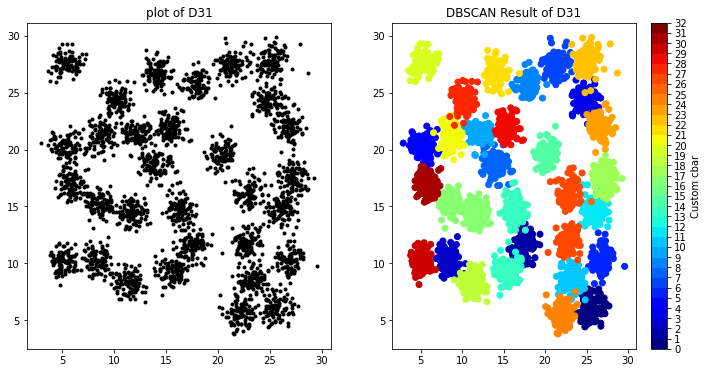

In [9]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
fileName = 'dataset/D31.txt'
X = plain_picture(fileName,ax)

start_time = time.time()

lines = sc.textFile(fileName, 5)
min_dis = 1.7
min_point = 6

data = lines.map(parseVector).cache()  # data is an RDD of arrays

sums = data.mapPartitions(f).collect()

for i in range(1, len(sums)):
    sums[i] += sums[i - 1]

# print(sums)

# allocate id
data_id = data.mapPartitionsWithIndex(give_id)

data_broad = data_id.collect()
data_total = sc.broadcast(data_broad)

# data = sc.parallelize(data_id, 4).cache()

data_length = data_id.count()

# reduce O(n) to O(n/p)
neighbourhood = data_id.mapPartitions(nearest_neighbour).cache()
# print(neighbourhood.collect())

data_calculate = neighbourhood.collect()
# print(data_calculate)

label_data = {}

# running in driver, not parallel
# initialize as {id : id}
for i in range(len(data_calculate)):
    label_data[data_calculate[i][0]] = data_calculate[i][0]

# print(label_data)

# put the first core point's id as the cluster_label
for i in range(len(data_calculate)):
    if data_calculate[i][1][1] >= min_point:
        cluster_label = label_data[data_calculate[i][0]]
        for idj in data_calculate[i][1][0]:
            label_data[idj] = cluster_label

# print(label_data)

label_set = []
clusters = -1
labelList = []
for i in range(1,len(label_data)+1):
    if label_data[i] not in label_set:
        label_set.append(label_data[i])
        clusters+=1
    labelList.append(clusters)
    
end_time = time.time()
print('naive_dbscan run time on D31.txt:', end_time - start_time)

processed_picture(X,ax,len(label_set),labelList,fileName)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
fileName = 'dataset/b2-sub-19.txt'
X = plain_picture(fileName,ax)

start_time = time.time()

lines = sc.textFile(fileName, 5)
min_dis = 2000
min_point = 5

data = lines.map(parseVector).cache()  # data is an RDD of arrays

sums = data.mapPartitions(f).collect()

for i in range(1, len(sums)):
    sums[i] += sums[i - 1]

# print(sums)

# allocate id
data_id = data.mapPartitionsWithIndex(give_id)

data_broad = data_id.collect()
data_total = sc.broadcast(data_broad)

# data = sc.parallelize(data_id, 4).cache()

data_length = data_id.count()

# reduce O(n) to O(n/p)
neighbourhood = data_id.mapPartitions(nearest_neighbour).cache()
# print(neighbourhood.collect())

data_calculate = neighbourhood.collect()
# print(data_calculate)

label_data = {}

# running in driver, not parallel
# initialize as {id : id}
for i in range(len(data_calculate)):
    label_data[data_calculate[i][0]] = data_calculate[i][0]

# print(label_data)

# put the first core point's id as the cluster_label
for i in range(len(data_calculate)):
    if data_calculate[i][1][1] >= min_point:
        cluster_label = label_data[data_calculate[i][0]]
        for idj in data_calculate[i][1][0]:
            label_data[idj] = cluster_label

# print(label_data)

label_set = []
clusters = -1
labelList = []
for i in range(1,len(label_data)+1):
    if label_data[i] not in label_set:
        label_set.append(label_data[i])
        clusters+=1
    labelList.append(clusters)
    
end_time = time.time()
print('naive_dbscan run time on flame.txt:', end_time - start_time)

processed_picture(X,ax,len(label_set),labelList,fileName)